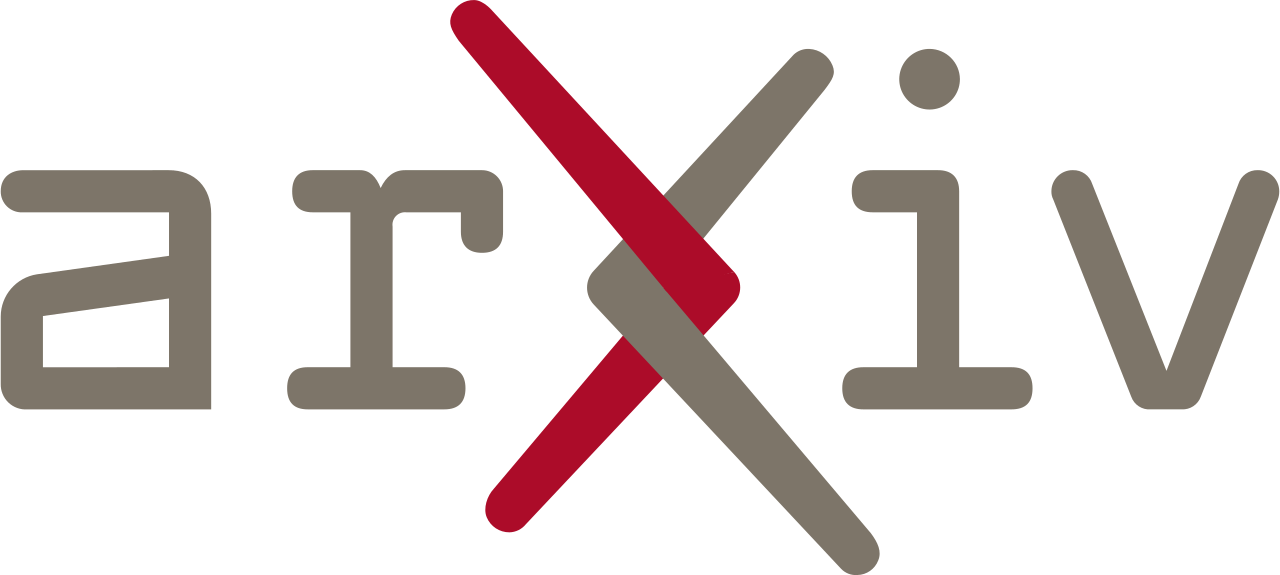

<h1 style = "font-family: monospace">The arXiv dataset</h1>
<p>The arXiv is an open-access preprint repository for scientific articles, that was started in 1991 by a physicist Paul Ginsparg. The website currently hosts more than two million research papers. A regularly updated dataset is avaialble from download on Kaggle: <a href = "https://www.kaggle.com/datasets/Cornell-University/arxiv">www.kaggle.com/datasets/Cornell-University/arxiv</a> The dataset contains metadata for all publications currently available on arXiv, including title and abstract for each record. Full-text for every paper can be downloaded separately. For this basic analysis, we are going to work with abstracts though.</p>
<p>Start by importing modules that will be required in the analysis:</p>

In [2]:
using DataFrames
using JSON3
using TextAnalysis
using WordTokenizers
using Chain
using Embeddings
using ParallelKMeans
using Luxor
using ColorSchemes
using Plots
using Printf
using PyCall
using Images
using ProgressMeter

# alternative library for trainig word2vec embeddings
import Word2Vec as Word2VecTrain

# using Python module for drawing word clouds
@pyimport wordcloud

I have downloaded and unpacked the dataset manually, so I will load it from disk:

In [3]:
dataset = "datasets/arxiv-metadata-oai-2024-04-15.json" ;

This dataset is not in a CSV format, but rather uses a JSON format to encode every record line-by-line, so we read it using a JSON module:

In [4]:
dataframe = JSON3.read.(eachline(dataset)) |> DataFrame ;

Now let's have a look at what columns are available at the loaded dataframe:

In [5]:
names(dataframe)

12-element Vector{String}:
 "id"
 "submitter"
 "authors"
 "title"
 "comments"
 "journal-ref"
 "doi"
 "abstract"
 "report-no"
 "categories"
 "versions"
 "versions_dates"

<h3>Yearly number of AI submissions</h3>

We are going to plot the number of papers about AI year by year. Columns <i>categories</i>, <i>versions</i> and <i>versions_dates</i> can probably contain useful information to do the task. Let's display the values of these columns for the first 8 records:

In [6]:
dataframe[1:8, ["title", "categories", "versions", "versions_dates"]]

Row,title,categories,versions,versions_dates
,String,Array…,Array…,Array…
1,Calculation of prompt diphoton production cross sections at Tevatron and\n LHC energies,"[""hep-ph""]","[""v1"", ""v2""]","[""Mon, 2 Apr 2007 19:18:42 GMT"", ""Tue, 24 Jul 2007 20:10:27 GMT""]"
2,Sparsity-certifying Graph Decompositions,"[""math.CO cs.CG""]","[""v1"", ""v2""]","[""Sat, 31 Mar 2007 02:26:18 GMT"", ""Sat, 13 Dec 2008 17:26:00 GMT""]"
3,The evolution of the Earth-Moon system based on the dark matter field\n fluid model,"[""physics.gen-ph""]","[""v1"", ""v2"", ""v3""]","[""Sun, 1 Apr 2007 20:46:54 GMT"", ""Sat, 8 Dec 2007 23:47:24 GMT"", ""Sun, 13 Jan 2008 00:36:28 GMT""]"
4,A determinant of Stirling cycle numbers counts unlabeled acyclic\n single-source automata,"[""math.CO""]","[""v1""]","[""Sat, 31 Mar 2007 03:16:14 GMT""]"
5,From dyadic $\\Lambda_{\\alpha}$ to $\\Lambda_{\\alpha}$,"[""math.CA math.FA""]","[""v1""]","[""Mon, 2 Apr 2007 18:09:58 GMT""]"
6,Bosonic characters of atomic Cooper pairs across resonance,"[""cond-mat.mes-hall""]","[""v1""]","[""Sat, 31 Mar 2007 04:24:59 GMT""]"
7,Polymer Quantum Mechanics and its Continuum Limit,"[""gr-qc""]","[""v1"", ""v2""]","[""Sat, 31 Mar 2007 04:27:22 GMT"", ""Wed, 22 Aug 2007 22:42:11 GMT""]"
8,Numerical solution of shock and ramp compression for general material\n properties,"[""cond-mat.mtrl-sci""]","[""v1"", ""v2"", ""v3""]","[""Sat, 31 Mar 2007 04:47:20 GMT"", ""Thu, 10 Apr 2008 08:42:28 GMT"", ""Tue, 1 Jul 2008 18:54:28 GMT""]"


As can be seen from the table, these columns cannot be used directly and must be pre-processed into convenient format for further analysis. First, I'm going to create a <i>year</i> column for every paper, based on the submission date of the first version:

In [7]:
# notice Julia indexes arrays starting from 1
transform!(dataframe, :versions_dates => ByRow(dates -> parse(Int16, split(dates[1], " ")[4])) => :year)
describe(dataframe[!, :year])

Summary Stats:
Length:         2459557
Missing Count:  0
Mean:           2014.604524
Std. Deviation: 7.432533
Minimum:        1986.000000
1st Quartile:   2010.000000
Median:         2017.000000
3rd Quartile:   2021.000000
Maximum:        2024.000000
Type:           Int16


As can be seen from quick statistics above, the dataset contains <i>2,448,241</i> records starting from year 1986 up to the present year 2024. The number of submissions should have been growing with time, because the mean year is 2014. Now let's search the dataframe for some papers about articficial intelligence:

In [8]:
filter(r -> occursin("Artificial Intelligence", r["title"]), dataframe)[!, ["title", "year", "categories"]]

Row,title,year,categories
,String,Int16,Array…
1,Artificial Intelligence for Conflict Management,2007,"[""cs.AI""]"
2,The Road to Quantum Artificial Intelligence,2007,"[""cs.AI""]"
3,The Role of Artificial Intelligence Technologies in Crisis Response,2008,"[""cs.AI""]"
4,Artificial Intelligence Approach to the Determination of Physical\n Properties of Eclipsing Binaries. I. The EBAI Project,2008,"[""astro-ph""]"
5,Artificial Intelligence Techniques for Steam Generator Modelling,2008,"[""cs.AI""]"
6,Text Classification using Artificial Intelligence,2010,"[""cs.IR""]"
7,Artificial Intelligence in Reverse Supply Chain Management: The State of\n the Art,2010,"[""cs.AI""]"
8,Algorithmic Randomness as Foundation of Inductive Reasoning and\n Artificial Intelligence,2011,"[""cs.IT cs.AI cs.CC math.IT""]"
9,"Quantum Interaction Approach in Cognition, Artificial Intelligence and\n Robotics",2011,"[""cs.AI cs.RO quant-ph""]"


As can be seen from the listing above, each article can belong to several areas of research, that are separated by space. There are general areas such as <i>math</i> and sub-areas, that are specified by dot after the name of general area. The artificial intelligence is a sub-area of computer science, denoted by <i>cs.AI</i> category. I will create a separate column in the table, that will be set to <i>True</i> if paper belongs to this category, and plot a histogram for this column:

Total number of submissions in computer science . AI category: 86512 
Number AI paper submissions to arXiv by year:

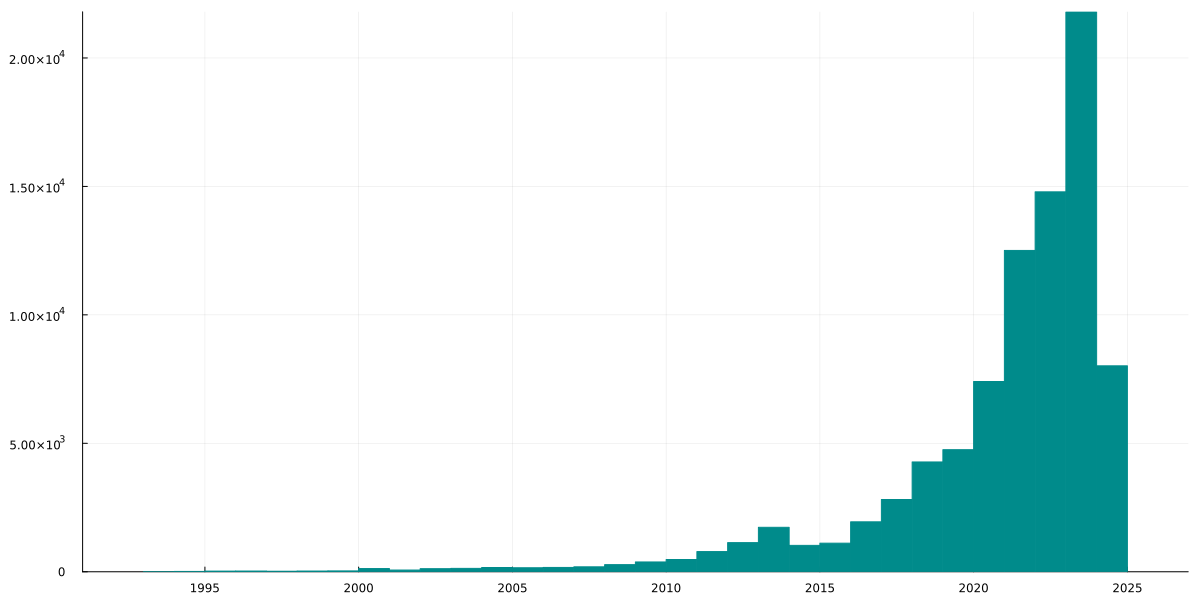

In [9]:
transform!(dataframe, :categories => ByRow(cats -> occursin("cs.AI", cats[1])) => :AI)

result = histogram(dataframe[dataframe.AI .== true, :year], bins = 38,
    fill=true, linecolor=:darkcyan, fillcolor=:darkcyan, legend = false, size = (1200, 600))

total = sum(dataframe[!, :AI])
@printf "Total number of submissions in computer science . AI category: %i \nNumber AI paper submissions to arXiv by year:" total

display(result)

As can be seen from the graph, the number of AI papers went sharply up in the last couple of years.

Let's calculate how many publications are in each area of research. We are going to calculate the number of publications in general areas. To do this, I'm going to transform the categories column, extracting general areas for every publication as a set of strings:

In [10]:
transform!(dataframe, :categories => ByRow(cats -> Set(map(ca -> split(ca, ".")[1], split(cats[1], " ")))) => :areas)
dataframe.areas

2459557-element Vector{Set{SubString{String}}}:
 Set(["hep-ph"])
 Set(["math", "cs"])
 Set(["physics"])
 Set(["math"])
 Set(["math"])
 Set(["cond-mat"])
 Set(["gr-qc"])
 Set(["cond-mat"])
 Set(["astro-ph"])
 Set(["math"])
 Set(["math"])
 Set(["math"])
 Set(["math"])
 ⋮
 Set(["cond-mat", "supr-con", "quant-ph"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])
 Set(["cond-mat", "supr-con"])

<h2>Visualizing areas of research</h2>

Now we are going to calculate the number of publications in every area. To do this, I will add a binary column for each unique area, indicating if publication belongs to that area. After that, the sum of each column will be calculated and stored in dictionary:

In [11]:
general = Set() # set that will store all available general areas
uniques(areas) = push!(general, areas...) # function to collect general areas 
uniques.(dataframe.areas) # apply funtion to every row in the dataframe

# create a column for every area of science in arXiv
for area in general
    dataframe[!, area] = ifelse.( area .∈ dataframe[!, :areas], true, false)
end

# count the number of publications in every area and sort the result
areas = Dict()
for area in general
    areas[area] = sum(dataframe[!, area])
end

areas = sort(areas, byvalue = true, order = Base.Order.Reverse)
areas

OrderedCollections.OrderedDict{Any, Any} with 38 entries:
  "math"     => 637648
  "cs"       => 614714
  "cond-mat" => 368632
  "astro-ph" => 339683
  "physics"  => 251887
  "hep-ph"   => 178673
  "hep-th"   => 165033
  "quant-ph" => 146241
  "stat"     => 117459
  "gr-qc"    => 106034
  "eess"     => 82486
  "math-ph"  => 78549
  "nucl-th"  => 56636
  "hep-ex"   => 53144
  "q-bio"    => 44903
  "nlin"     => 42162
  "hep-lat"  => 27738
  "nucl-ex"  => 25527
  "q-fin"    => 18842
  "econ"     => 9560
  "chao-dyn" => 2398
  "q-alg"    => 1578
  "alg-geom" => 1423
  "solv-int" => 1413
  "cmp-lg"   => 894
  ⋮          => ⋮

Now that we have counted the number of publications, we can visualize the result. Using Julia module <i>Luxor</i> I will paint a circle for each one of N largest fields of science, with the area of circle equal to number of papers:

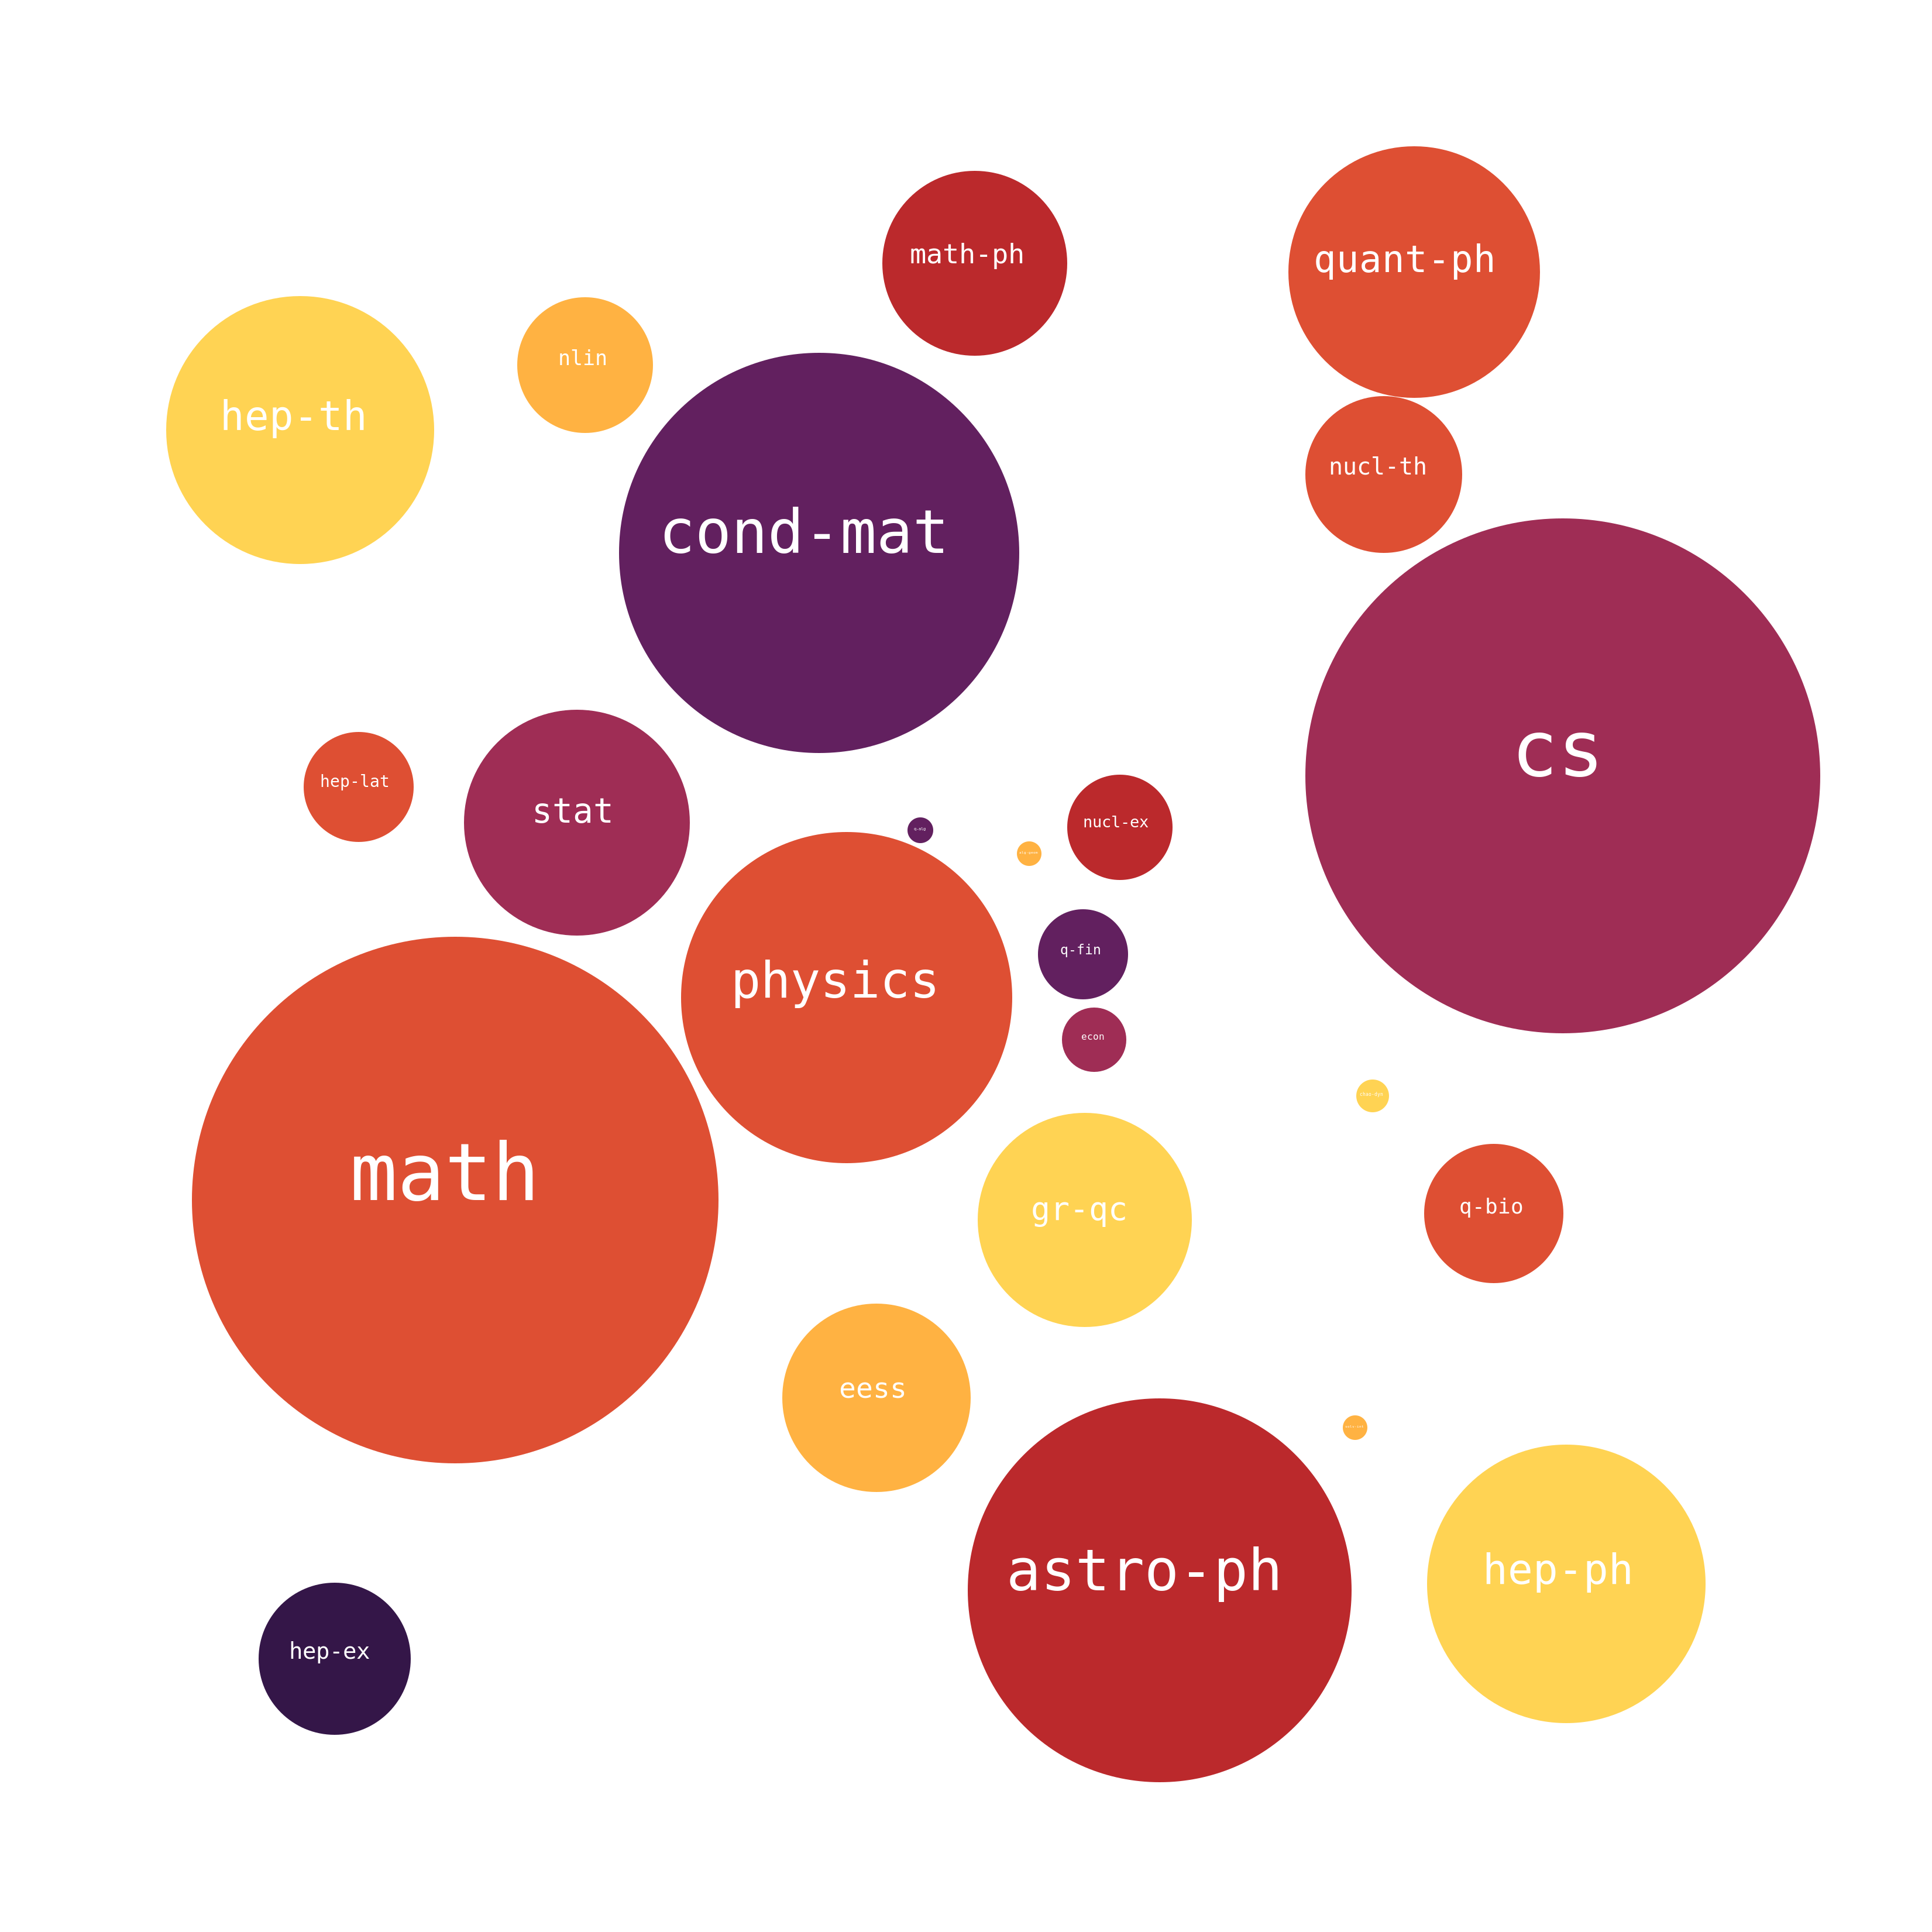

In [12]:
N = 24
top = collect(first(areas, N)) # select N most populated fields

radii = [round(sqrt(S/π)) for (area, S) in top] # calculate circle radius for every field
width = height = round(sum(radii) * 0.8) # calculate picture size to fit all circles
rm = maximum(radii)
points = Set([(x, y) for x in rm:(width-rm), y in rm:(height-rm)]) # a set of all (x,y) points on the picture
circles = []

@png begin
    x = y = 0
    origin( Point(0, 0) )
    fontface("monospace")

    # paint all areas of science as circles
    for (area, S) in top
        r = round(sqrt(S/π))
        fontsize(round(r * 0.3))

        # randomly place circle, repeat if it overlaps with others
        overlap = true
        while overlap
            x, y = rand(points)
            overlap = false
            for (xi, yi, ri) in circles
                distance = norm([x, y] - [xi, yi])
                if distance < r + ri
                    overlap = true
                    break
                end
            end
        end
        ci = rand(colorschemes[:Tam].colors) # get random color from the palette

        sethue(ci)
        circle(Point(x, y), r, :fill) # draw the circle

        sethue("white")
        Luxor.text(area, Point(round(x - length(area) * r * 0.1), y)) # output name of the research area
        
        push!(circles, (x, y, r))

        # remove points that were occupied by circle
        fill = Set([(xi, yi) for xi in (x-r):(x+r), yi in (y-r):(y+r)])
        points = setdiff(points, fill)
        
    end
end width height "circles.png"

As can be seen from the figure above, most populated research areas are mathematics and computer science, followed by general physics, astrophysics and physics of condensed matter.

<h2>Visualizing AI wordcloud</h2>

Let's select titles and abstracts of all papers from AI field and see most frequent words used. First, I will select a subset of AI papers from dataset:

In [12]:
aipapers = dataframe[dataframe.AI .== true, [:title, :abstract]] ;

Now we are going to use Python's package since it is currently the best one for drawing word clouds:

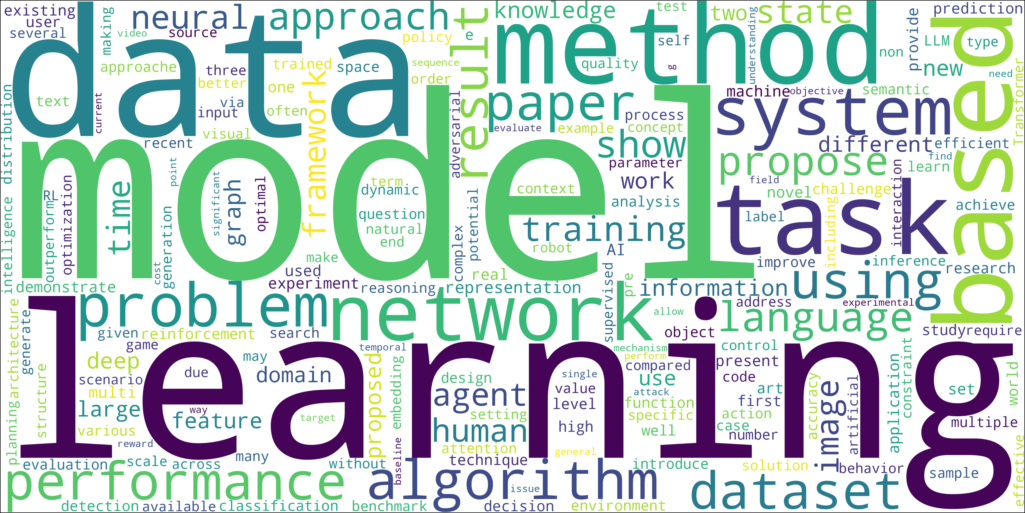

In [15]:
# collect all titles and abstracts into single text string
t = Vector(aipapers[!, :title])
a = Vector(aipapers[!, :abstract])
words = join(t, "\n") * "\n\n" * join(a, "\n\n")

# create world cloud from the string
cloud = wordcloud.WordCloud(collocations = false, background_color = "white", width = 4096, height = 2048).generate(words)
cloud.to_file("cloud.png")
IJulia.display(load("cloud.png"))

<h2>Semantic word clustering</h2>

It might be interesting to see which words are not only most frequent, but are also semantically linked, i.e. used in the same contexts. The basic way to do this is to use pre-trained word2vec word embeddings. The word2vec neural network was pre-trained on part of Google News dataset consisting of about 100 billion words, and provides 300-dimensional vector embeddings for 3 million words and phrases. I'm going to load it using Julia <i>Embeddings</i> package:

In [13]:
emtable = load_embeddings(Word2Vec, "datasets/GoogleNews-vectors-negative300.bin")
emindex = Dict(word => i for (i, word) in enumerate(emtable.vocab))

Dict{String, Int64} with 929022 entries:
  "Tencent"           => 69121
  "5IP"               => 539914
  "Sawtelle"          => 136142
  "Patchway"          => 308084
  "titration"         => 121278
  "Misrule"           => 235915
  "Danderson"         => 486555
  "Bigbie"            => 102277
  "Francel"           => 279181
  "WealthCentral"     => 575705
  "Montiy"            => 664165
  "Konigsmark"        => 731590
  "Commis"            => 336102
  "entomb"            => 189686
  "Notch"             => 76478
  "DUGAS"             => 437342
  "Piliang"           => 825975
  "Papahanaumokuakea" => 429911
  "HID"               => 78629
  "Skaw"              => 542340
  "LWIB"              => 589261
  "Pettine"           => 131546
  "Scabbers"          => 676350
  "Core"              => 11282
  "Sofya"             => 224129
  ⋮                   => ⋮

Now I'm going to build lexicon of all words used in abstracts of publications about AI. Since words in embedding table are case-sensitive, I will create a separate dictionary for case-insensitive vector search:

In [14]:
emlower = Dict()
for (word, i) in emindex
    lw = lowercase(word)
    if lw ∉ keys(emindex)
        emlower[lw] = i
    end
end

Next I will select all abstracts as single document and tokenize it:

In [15]:
aibstracts = join(Vector(aipapers[!, :abstract]), "\n\n")
aibstracts = reduce(vcat, nltk_word_tokenize.(split_sentences(aibstracts)))
aibstracts = TokenDocument(aibstracts)

A TokenDocument{String}
 * Language: Languages.English()
 * Title: Untitled Document
 * Author: Unknown Author
 * Timestamp: Unknown Time
 * Snippet: ***SAMPLE TEXT NOT AVAILABLE***

Having this done, we can create a lexicon of all words used in abstracts:

In [17]:
aicorpus = Corpus([aibstracts])
update_lexicon!(aicorpus)

aiwords = sort(lexicon(aicorpus), byvalue = true, order = Base.Order.Reverse)
aiwords = keys(Dict(aiwords)) # to select top N words first(aiwords, N) can be used

KeySet for a Dict{String, Int64} with 203815 entries. Keys:
  "Tencent"
  "HAPs"
  "end-objective"
  "spectrum-preservative"
  "preference-based"
  "single-arm"
  "photosynthesis"
  "GRU-"
  "SMNNs"
  "text-conditional"
  "BioLAMA"
  "DA-BCM"
  "PDTB"
  "Unknown-semantic-region"
  "outcome-graded"
  "HID"
  "WiDs"
  "pseudo-label"
  "BP-based"
  "Core"
  "double-scale"
  "SE-interpretations"
  "EEEC"
  "sub-slot"
  "out-ofmodel-scope"
  ⋮

Now I will create a dictionary with vector assigned to every token in the lexicon. First, the function will lookup for the same-case token in the embeddings table, if that is not available, then embedding for lowercased token will be searched.

In [18]:
function vectorize(word, N)
    if word in keys(emindex)
        emtable.embeddings[:, emindex[word]]
    elseif word != lowercase(word)
        vectorize(lowercase(word), N)
    elseif word in keys(emlower)
        emtable.embeddings[:, emlower[word]]
    else
        Float32.(vec(zeros(1, N)))
    end   
end

vectors = Dict()
@showprogress for word in aiwords
    vectori = vectorize(word, 300)
    if !iszero(vectori)
        vectors[word] = vectori
    end
end

vectors

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07m


Dict{Any, Any} with 72395 entries:
  "Tencent"        => Float32[0.104523, -0.009799, -0.0287437, -0.0281499, -0.0…
  "HAPs"           => Float32[-0.0783262, -0.0329051, 0.0710588, -0.042393, -0.…
  "rearrangement"  => Float32[0.0111418, -0.00705409, -0.0329914, 0.0642465, -0…
  "MSW"            => Float32[-0.0598557, -0.0712429, 0.00583958, 0.0197086, -0…
  "inattentive"    => Float32[0.0652032, -0.0481262, -0.0246841, 0.0484367, -0.…
  "photosynthesis" => Float32[0.0612708, 0.0704406, -0.00625212, -0.0523094, -0…
  "Topological"    => Float32[-0.0482567, -0.0639615, 0.00920874, -0.0177036, 0…
  "rectly"         => Float32[-0.050698, -0.0161565, -0.0493052, 0.10251, -0.02…
  "dehydrogenase"  => Float32[-0.0790041, -0.0722599, 0.0123645, -0.00118426, -…
  "NLG"            => Float32[-0.0406121, -0.0546701, -0.00135699, 0.0905962, -…
  "ictal"          => Float32[-0.0595719, -0.0163891, 0.0201293, 0.0364504, -0.…
  "HID"            => Float32[0.0742393, -0.0143065, 0.0386663, -0.0181732

The embedding vectors were successfully for 36% of the lexicon. Now we can perform K-means clustering on these vectors. Since the vocavulary is quite large, I will set up the number of clusters to a reasonably high number 256, which means around 500 words per cluster:

In [22]:
X = hcat(values(vectors)...) # put all word vectors to a matrix for processing
result = ParallelKMeans.kmeans(X, 512)

ParallelKMeans.KmeansResult{Matrix{Float32}, Float32, Float32}(Float32[0.0020617507 0.047016848 … -0.014872757 0.04528707; 0.012827023 -0.027708372 … -0.017139481 0.02203983; … ; 0.00038435496 -0.00093901734 … 0.009338045 -0.015210896; -0.0073432135 0.0519048 … -0.013250979 -0.011416535], [190, 241, 17, 499, 200, 171, 270, 482, 329, 219  …  125, 148, 47, 59, 433, 188, 466, 497, 66, 288], Float32[], Int64[], Float32[], 50115.0f0, 65, true)

Now I'm going to write a few functions to view the results of clustering:

In [23]:
# this function will assign a cluster to each word based on k-means result, returning a sorted dictionary
function getclusters(vectors, kresult)
    clusters = Dict()
    words = collect(keys(vectors))
    for i in 1:length(kresult.assignments)
        clusters[words[i]] = kresult.assignments[i]
    end    
    sort(clusters, byvalue = true)
end

# the function will take word-cluster dictionary and print clusters and words in these clusters
function viewclusters(clusters, maxwords = 48)
    current = 0
    v = 0
    for (wi, cli) in clusters
        if cli > current
            @printf "\n\ncluster %i: %s" cli wi
            current = cli
            v = 1
        elseif v < maxwords
            @printf ", %s" wi
            v = v + 1
        end
    end
end

# view the results of K-Means clustering
wordclusters = getclusters(vectors, result)
viewclusters(wordclusters)



cluster 1: divide, divides, demarcating, cRoss, separation, DividE, Bisection, BISECT, redraw, demarcate, stretching, clearcut, delimited, buffer, crosses, bordering, recrossing, BOundary, BoundarieS, separating, line, delineating, splits, side, borders, cross, buffers, ReDRAW, delineations, border, delimit, partition, sides, territorial, demarcated, Blurring, blurring, bifurcates, boundary, bracketing, lines, beween, porous, bOundary, straddle, bisecting, redraws, barrier

cluster 2: intentionality, verbalization, typologies, HierarchiCal, veridical, Posteriori, isomorphic, Psycholinguistic, SeMantic, Contrastive, ONTOLOGY, contextualisation, Dichotomous, qualia, Chatbots, TEMPoral, Disjoint, synthesises, trigonometric, computable, Hierarchic, invariants, ascriptions, spatial, individualizing, dialogic, simplifier, Heuristically, dialogical, compartmentalisation, semantic, hierarchical, percepts, subfield, psycholinguistic, hierarchic, analogical, Categorizations, disjoint, ontology

The clusters above make sence. It will be interesting to find out which cluster does the word <i>intelligence</i> belong to:

In [24]:
function wordcluster(clusters, word)
    i = clusters[word]
    collect(keys(filter(((w, c),) -> c == i, clusters)))
end

cluster = wordcluster(wordclusters, "intelligence")
@printf "The word %s belongs to cluster: %s" "intelligence" join(cluster, ", ")

The word intelligence belongs to cluster: interrogator, Terrorist, KSM, terrorism, VBIED, civilians, Westerners, intelligence, defector, PKK, aqi, PoW, operatives, INtelligence, terrorists, jihadist, intel, ReBeL, diplomatic, WMD, rearm, attacks, Iraq, Taliban, aTtack, militant, terror, weapons, iNtelligence, rearming, airstrikes, extremists, bombs, rebel, Intelligence, enemy, bombing, exfiltrating, OBL, Afghanistan, Syria, tortured, spies, gunfighting, Baghdad, ATtack, exfiltrate, insurgency, landmine, Pakistani, combatants, dissidents, prisoners, Mosul, infiltrations, missiles, IARA, bomb, explosives, interrogators, terrorist, CIA, Iraqi, forces, spy, NIE, IED, defectors, Tehran, insurgents, Iran, insurgent, attack, bioweapons, peacekeepers, Saddam, tradecraft, weaponization, AQI, infiltrator, interrogation, interrogations, extremist, informants, Karadzic

The result is very interesting: even though the clustering makes sense, intelligence here seems to have nothing to do with <i>artificial intelligence</i> in technological sense. That can be the result of training word2vec algorithm on news texts. In the next section I'm going to train word2vec neural network on AI publications and see if the result will be different.

<h2>Training word2vec on specialized texts</h2>

I'm going to use a special package for training word2vec that takes text file as an input:

In [25]:
# save abstracts for publications about AI to text file
open("aipapers.txt", "w") do file
    write(file, join(tokens(aibstracts), " "))
end

# train the model and save the result to aipapers file
Word2VecTrain.word2vec("aipapers.txt", "aipapers", verbose = true)

Starting training using file aipapers.txt
Vocab size: 46592
Words in train file: 16371647
Alpha: 0.001667  Progress: 93.35%  Words/thread/sec: 361.90k  

Process(`/home/jupyter-alexandra/.julia/artifacts/0c86f7feb8f6b4ab5f9fb793f1fde1278e3a6021/bin/word2vec -train aipapers.txt -output aipapers -size 100 -window 5 -sample 0.001 -hs 0 -negative 5 -threads 12 -iter 5 -min-count 5 -alpha 0.025 -debug 2 -binary 0 -cbow 1`, ProcessExited(0))

Now we can load the trained model to get the embeddings:

In [26]:
model = Word2VecTrain.wordvectors("./aipapers")

WordVectors 46592 words, 100-element Float64 vectors

After the model is loaded, I will create a dictionary that will containt a vector embedding for every word in the lexicon:

In [31]:
vecspec = Dict()

@showprogress for word in aiwords
    if Word2VecTrain.in_vocabulary(model, word)
        vecspec[word] = Word2VecTrain.get_vector(model, word)
    elseif Word2VecTrain.in_vocabulary(model, lowercase(word))
        vecspec[word] = Word2VecTrain.get_vector(model, lowercase(word))
    end
end

vecspec

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


Dict{Any, Any} with 57832 entries:
  "Tencent"          => [0.0689068, -0.0575573, -0.0172092, 0.0472487, -0.00253…
  "HAPs"             => [0.0413372, -0.0405988, -0.0404009, 0.12459, -0.0859556…
  "rearrangement"    => [-0.0013575, 0.0305184, 0.17457, -0.0253614, 0.0764663,…
  "preference-based" => [0.19194, -0.0857611, 0.0598874, 0.0555546, -0.0652514,…
  "single-arm"       => [-0.0104827, -0.219827, 0.00707405, 0.0360821, -0.00157…
  "inattentive"      => [0.154889, -0.157708, 0.181607, -0.057272, -0.0605871, …
  "Synsets"          => [-0.0914045, -0.111335, 0.181944, -0.134582, 0.0473605,…
  "photosynthesis"   => [-0.0415918, -0.195309, 0.00760332, -0.0466779, 0.08486…
  "SMNNs"            => [0.0373311, -0.192662, -0.0540086, 0.105392, 0.0788419,…
  "Topological"      => [-0.0256136, 0.0217798, 0.0639474, 0.121109, 0.121274, …
  "DSSL"             => [0.0680882, -0.0516265, -0.0102028, 0.0170844, -0.02930…
  "PDTB"             => [-0.00564273, -0.206437, 0.0274409, -0.0425553, 0.

Now we can run a K-Means clustering al

In [32]:
X = hcat(values(vecspec)...)
result = ParallelKMeans.kmeans(X, 512)

ParallelKMeans.KmeansResult{Matrix{Float64}, Float64, Float64}([0.031158444979843436 0.00022946911362206772 … -0.025855676095211205 -0.07362564568131606; 0.00462897810677712 -0.11258507767417454 … -0.04571692555472901 -0.016568089837003818; … ; 0.15760557347246487 -0.04067843260828309 … 0.0501609309312863 -0.08736439826000773; 0.013273666945954974 0.05124661732735545 … 0.10070062622167109 0.03421112992684715], [304, 411, 323, 22, 206, 437, 137, 92, 224, 482  …  286, 59, 146, 294, 60, 378, 401, 18, 245, 250], Float64[], Int64[], Float64[], 27631.99340995507, 60, true)

In [33]:
speclusters = getclusters(vecspec, result)
cluster = wordcluster(speclusters, "intelligence")
@printf "The word %s belongs to cluster: %s" "intelligence" join(cluster, ", ")

The word intelligence belongs to cluster: humans, chemistries, understanding, brains, intelligence, animals, beings, minds, interaction, Dilemmas, Innate, INteraction, life, impairments, INtelligence, COoperation, Childhood, lIving, reflection, conscious, compositionality, Morality, Chemistries, liFe, Creatures, FiSH, mind, sciences, organisms, Bodies, cognitive, appraisal, INTELLIGENCE, thinking, gameplay, embodiment, iNtelligence, creatures, mathematicians, ToM, living, cooperation, Functioning, childhood, perceptions, interactiOn, empathy, creativity, Mathematicians, Metaphors, metaphors, societies, fish, COgnitive, Beings, morality, Embodiment, collaboration, infants, CoGnition, formation, consciousness, Perceptions, expertise, requisites, involvement, faculties, nuances, developmental, agency, underStanding, Organisms, Societies, COGnitive, undERstanding, workings, bodies, InteraCtion, cognition, inTeraction, Empathy, wisdom, self-awareness, Observers, functioning, dilemmas, Appra

In this case, the word <i>intelligence</i> now belongs with other terms about cognition and perception. Training neural embeddings on specialized texts can therefore yield very different results.